<a href="https://colab.research.google.com/github/GauravPatel89/EVA-Track3-Assignments/blob/master/Session10/Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries and modules**

In [0]:
#Import necessary modules
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

from keras import backend as K
from google.colab.patches import cv2_imshow

# GRADCAM

Let's start with a pretrained VGG model

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

## **Part1:**
Obtain GradCam outputs for given image on last layer,one layer before last and two layers before last layer.

1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [0]:
model = VGG16(weights="imagenet")
from skimage import io
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

We will define a function implementing the GradCam so that we can reuse it for different layers, inputs and class Ids. We needn't repeat the same code multiple times.

In [0]:
# Define function to apply gradCam algorithm. Defining function for this 
# allows reusability.


def computeGradCam(model,layerName,inputImage,preProcessedImage,classId = -1): 
  """
  Given cnn model,layer name,original untouched image, preprocessed image and 
  image id, this function applies gradCam algorithm on the model for given layer and 
  input image for provided class id and returns the image with heatmap superimposed over it.

  Parameters:
  model - Trained cnn model for which gradCam is required
  layerName - Name of the model layer at which gradCam is to be applied
  inputImage - Original untouched input image
  preProcessedImage - Image with necessary preprocessing for given model
  classId - '-1' should be passed if GradCam on model predicted class is required. else 
              class id w.r.t which gradCam is to be calculated must be passed   

  Returns: Image with gradCam heatmap superimposed on the image from original dataset                             
  """ 

  # Get model prediction for given input image
  preds = model.predict(preProcessedImage)

  # Decide the class Id
  if classId == -1:  # use prediction obtained from trained model
    class_idx = np.argmax(preds[0])
  else:              # otherwise use the class id passed as argument
    class_idx = classId

  # Take output for the given class Id
  class_output = model.output[:, class_idx]
  # Get the convolution layer for which GradCam is required
  conv_layer = model.get_layer(layerName)

  # Compute the gradient of the class output value with respect to the feature map
  grads = K.gradients(class_output,conv_layer.output)[0]
  
  # Pool the gradients over all the axes leaving out the channel dimension
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
  iterate = K.function([model.input], [pooled_grads, conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])

  # Weigh the output feature map with the computed gradient values
  for i in range(conv_layer.output_shape[3]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  # Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)

  # Normalize the heat map to make the values between 0 and 1
  heatmap /= np.max(heatmap)    

  # Resize the heatmap to match its size with that of input image
  heatmap = cv2.resize(heatmap, (inputImage.shape[1], inputImage.shape[0]))
  heatmap = np.uint8(255 * heatmap)

  # Get a heatmap by applying opencv colormap
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  # Superimpose the heatmap over the original image
  superimposed_img = cv2.addWeighted(inputImage, 0.5, heatmap, 0.5, 0)
  
  return superimposed_img


In [21]:
# Print the model summary and note the names layers for which GradCam is required
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
#From the model summary we see that last convolution layer before prediction
# layer is "block5_conv3" one before it is "block5_conv2" and one before this 
# is "block5_conv1"
last_conv_layer_name = "block5_conv3"
second_last_layer_name = "block5_conv2"
third_last_layer_name = "block5_conv1"

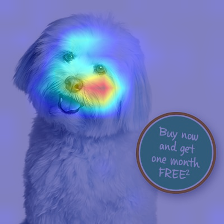

In [23]:
# Get GradCam for last layer
supImg_lastLayer = computeGradCam(model,last_conv_layer_name,dog,x,-1)
cv2_imshow(supImg_lastLayer)

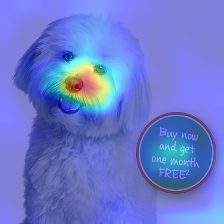

In [26]:
# Get GradCam for one layer before last layer
supImg_2ndlastLayer = computeGradCam(model,second_last_layer_name,dog,x,-1)
cv2_imshow(supImg_2ndlastLayer)

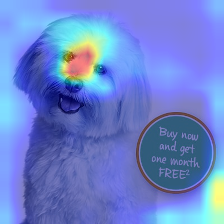

In [27]:
# Get GradCam for two layer before last layer
supImg_3rdlastLayer = computeGradCam(model,third_last_layer_name,dog,x,-1)
cv2_imshow(supImg_3rdlastLayer)

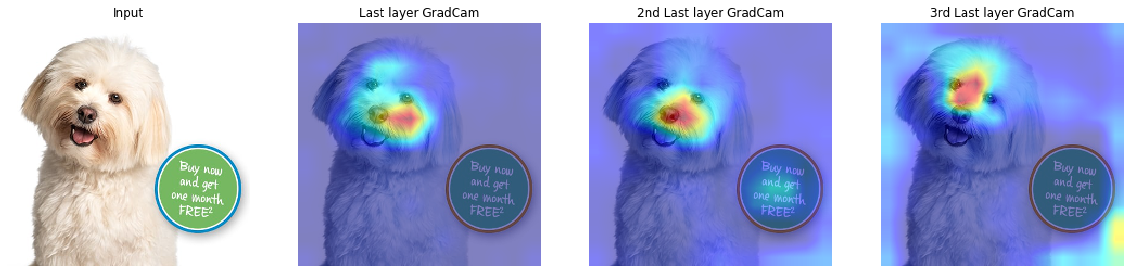

In [28]:
# Show all the outputs together

import matplotlib.pyplot as plt
% matplotlib inline

f, axarr = plt.subplots(1,4)

axarr[0].imshow(dog)
axarr[0].set_title('Input',fontsize=12)
axarr[0].axis('off')

axarr[1].imshow(cv2.cvtColor(supImg_lastLayer, cv2.COLOR_BGR2RGB))
axarr[1].set_title('Last layer GradCam',fontsize=12)
axarr[1].axis('off')

axarr[2].imshow(cv2.cvtColor(supImg_2ndlastLayer, cv2.COLOR_BGR2RGB))
axarr[2].set_title('2nd Last layer GradCam',fontsize=12)
axarr[2].axis('off')

axarr[3].imshow(cv2.cvtColor(supImg_3rdlastLayer, cv2.COLOR_BGR2RGB))
axarr[3].set_title('3rd Last layer GradCam',fontsize=12)
axarr[3].axis('off')

    
f.subplots_adjust(hspace=0.2)
f.set_size_inches(20,20)    

## **Part 2:**
Find sunglasses in image (https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg)

In [29]:
# To detect sunglasses we must first figure out class Id for 'sunglasses' class

# Import imagenet dataset json file and extract a list of all the class names
import json
from keras.utils.data_utils import get_file
CLASS_INDEX_PATH = ('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
fpath = get_file('imagenet_class_index.json',CLASS_INDEX_PATH,cache_subdir='models',file_hash='c2c37ea517e94d9795004a39431a14cb')
with open(fpath) as f:
  CLASS_INDEX = json.load(f)

# Now Search for 'sunglasses' class name and estimate its class id
classId = [classId for classId, classDetail in CLASS_INDEX.items() if classDetail[1] == 'sunglasses']
sunGlassesClassId = classId[0]
print(sunGlassesClassId)  

837


In [30]:
!pip install Pillow
from skimage import io
from PIL import Image
import requests

# Fetch the image from given url and load it
url = 'https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg'
inImage = Image.open(requests.get(url, stream=True).raw)
inImage = np.array(inImage)
inImage = cv2.resize(inImage, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(inImage)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

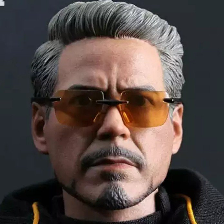

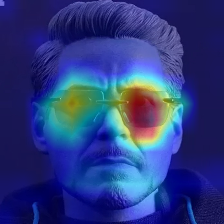

In [31]:
# Now detect the sunglasses
# We will perform GradCam on last layer for SunGlassesId we estimated earlier.
supImg_lastLayer = computeGradCam(model,last_conv_layer_name,inImage,x,int(sunGlassesClassId))
cv2_imshow(cv2.cvtColor(inImage, cv2.COLOR_RGB2BGR))
cv2_imshow(supImg_lastLayer)

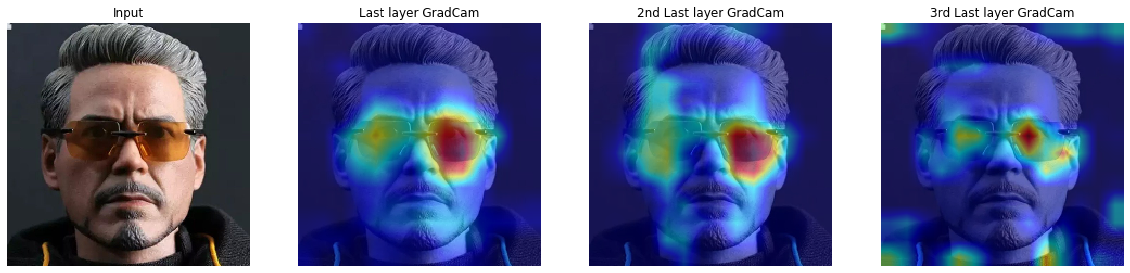

In [32]:
# We can generate GradCam results for layers before last layers 

import matplotlib.pyplot as plt
% matplotlib inline


supImg_2ndlastLayer = computeGradCam(model,second_last_layer_name,inImage,x,int(sunGlassesClassId))
supImg_3rdlastLayer = computeGradCam(model,third_last_layer_name,inImage,x,int(sunGlassesClassId))

f, axarr = plt.subplots(1,4)

axarr[0].imshow(inImage)
axarr[0].set_title('Input',fontsize=12)
axarr[0].axis('off')

axarr[1].imshow(cv2.cvtColor(supImg_lastLayer, cv2.COLOR_RGB2BGR))
axarr[1].set_title('Last layer GradCam',fontsize=12)
axarr[1].axis('off')

axarr[2].imshow(cv2.cvtColor(supImg_2ndlastLayer, cv2.COLOR_RGB2BGR))
axarr[2].set_title('2nd Last layer GradCam',fontsize=12)
axarr[2].axis('off')

axarr[3].imshow(cv2.cvtColor(supImg_3rdlastLayer, cv2.COLOR_RGB2BGR))
axarr[3].set_title('3rd Last layer GradCam',fontsize=12)
axarr[3].axis('off')

    
f.subplots_adjust(hspace=0.2)
f.set_size_inches(20,20)    